In [13]:
import os

DATA_DIR = os.path.join(os.path.abspath('..'), 'data')
DATA_NAME = 'healthcare-dataset-stroke-data.csv'

In [14]:
import pandas as pd

raw_data = pd.read_csv(os.path.join(DATA_DIR, DATA_NAME))
raw_data.drop('id', axis=1, inplace=True)


In [15]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [16]:
print(raw_data['work_type'].value_counts())
print(raw_data['Residence_type'].value_counts())
print(raw_data['smoking_status'].value_counts())

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


In [17]:
raw_data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


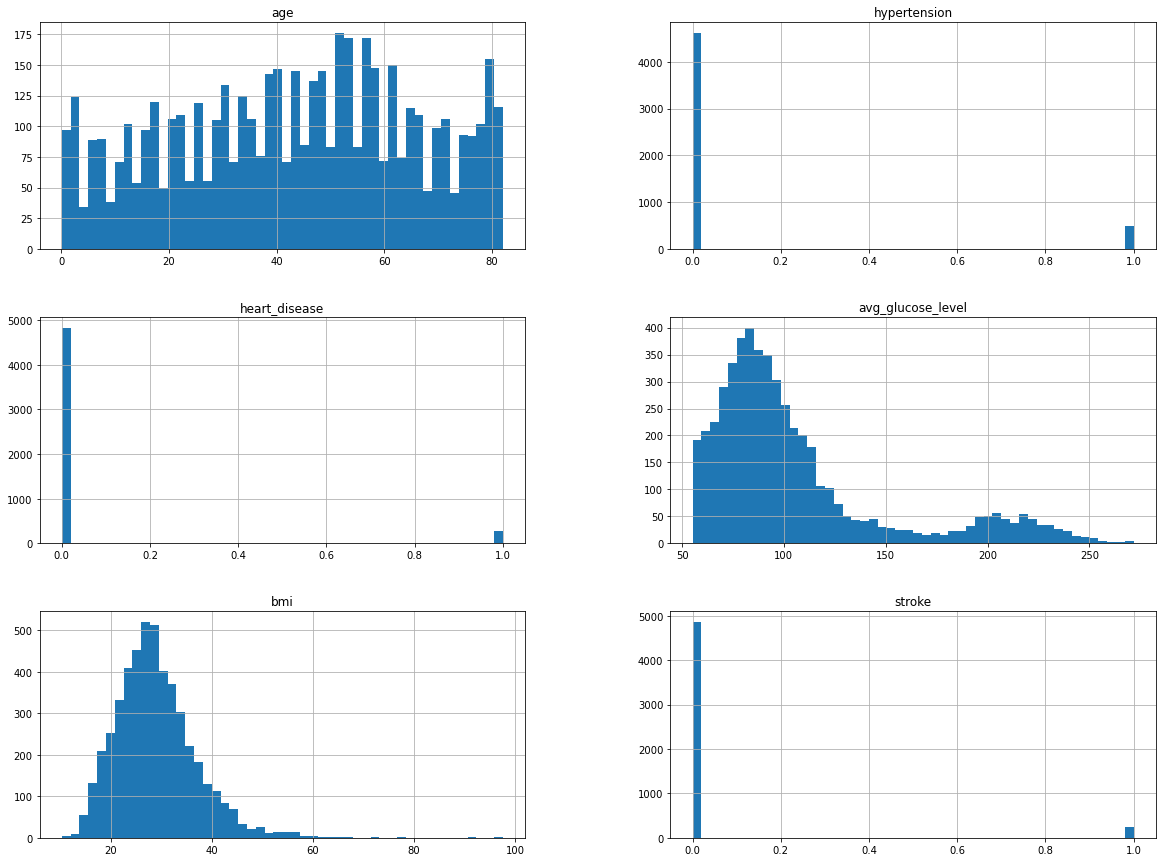

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
raw_data.hist(bins=50, figsize=(20,15))
plt.show()

0    4861
1     249
Name: stroke, dtype: int64
ratio: 19.522088353413654:1.0


<AxesSubplot:>

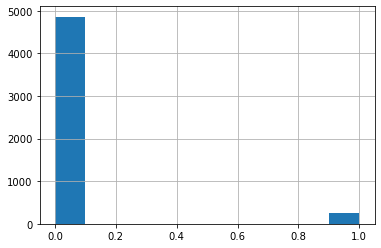

In [19]:
#This is clearly an imbalanced class (skewed datasets)

class_count = raw_data['stroke'].value_counts()

print(class_count)
print('ratio: ' + str(class_count[0]/class_count[1]) + ':' + str(class_count[1]/class_count[1]))

raw_data['stroke'].hist()


In [20]:
from sklearn.utils import resample

false_class = raw_data[raw_data['stroke'] == 0].copy()
true_class = raw_data[raw_data['stroke'] == 1].copy()

true_class_resampled = resample(true_class,
                                 replace=True,
                                 n_samples=len(false_class),
                                 random_state=22)

raw_data = pd.concat([true_class_resampled, false_class])


In [21]:
corr_matrix = raw_data.corr()
corr_matrix['stroke'].sort_values(ascending=False)

stroke               1.000000
age                  0.577701
avg_glucose_level    0.240729
hypertension         0.232250
heart_disease        0.206768
bmi                  0.105739
Name: stroke, dtype: float64

In [22]:
stroke_features = raw_data.drop(['bmi', 'stroke'], axis=1)
stroke_labels = raw_data['stroke'].copy()

In [23]:
stroke_features.isnull().count()

gender               9722
age                  9722
hypertension         9722
heart_disease        9722
ever_married         9722
work_type            9722
Residence_type       9722
avg_glucose_level    9722
smoking_status       9722
dtype: int64

In [24]:
from sklearn.preprocessing import OrdinalEncoder

for featureName in stroke_features.select_dtypes(include='O'):
    feature = stroke_features[[featureName]]
    orc_enc = OrdinalEncoder()
    encoded_feature = orc_enc.fit_transform(feature)
    stroke_features[featureName + '_encoded'] = encoded_feature

stroke_features = stroke_features.select_dtypes(exclude='O')

In [25]:
stroke_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9722 entries, 117 to 5109
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     9722 non-null   float64
 1   hypertension            9722 non-null   int64  
 2   heart_disease           9722 non-null   int64  
 3   avg_glucose_level       9722 non-null   float64
 4   gender_encoded          9722 non-null   float64
 5   ever_married_encoded    9722 non-null   float64
 6   work_type_encoded       9722 non-null   float64
 7   Residence_type_encoded  9722 non-null   float64
 8   smoking_status_encoded  9722 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 759.5 KB


In [26]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
stroke_features_tr = std_scaler.fit_transform(stroke_features)

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(stroke_features_tr, stroke_labels, random_state=22, test_size=0.2)

In [28]:
from sklearn.svm import SVC

svc_clf = SVC(gamma='auto', random_state=22)
svc_clf.fit(X_train, y_train)

SVC(gamma='auto', random_state=22)

In [29]:
from sklearn.model_selection import cross_val_score


cross_val_score(svc_clf, X_test, y_test, cv=3, scoring='roc_auc')

array([0.86683212, 0.84662629, 0.85816354])

In [30]:
from sklearn.metrics import confusion_matrix

predictions_train = svc_clf.predict(X_train)
predictions_test = svc_clf.predict(X_test)

print(confusion_matrix(y_train, predictions_train))
print(confusion_matrix(y_test, predictions_test))

[[2969  954]
 [ 450 3404]]
[[706 232]
 [100 907]]


In [31]:
from tensorflow import keras


X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size=0.2,
                                                      random_state=22)

model = keras.models.Sequential([
    keras.layers.Dense(128, activation=keras.activations.relu, input_shape=[9]),
    keras.layers.Dense(128, activation=keras.activations.relu),
    keras.layers.Dense(128, activation=keras.activations.relu),
    keras.layers.Dense(1, activation=keras.activations.sigmoid)
])

In [32]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.Recall()])

In [33]:
events_on_epoch = model.fit(X_train, y_train,epochs=1000,
                            validation_data=(X_valid, y_valid),
                            callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/1000
195/195 [==============================] - 0s 2ms/step - loss: 0.6417 - recall: 0.7906 - val_loss: 0.5913 - val_recall: 0.7648
Epoch 2/1000
195/195 [==============================] - 0s 1ms/step - loss: 0.5502 - recall: 0.7840 - val_loss: 0.5266 - val_recall: 0.7783
Epoch 3/1000
195/195 [==============================] - 0s 1ms/step - loss: 0.5063 - recall: 0.8060 - val_loss: 0.5022 - val_recall: 0.7968

In [34]:

predictions_train = (model.predict(X_train) > 0.5).astype('int32')
predictions_valid = (model.predict(X_valid) > 0.5).astype('int32')
predictions_test = (model.predict(X_test) > 0.5).astype('int32')

print(confusion_matrix(y_train, predictions_train))
print(confusion_matrix(y_valid, predictions_valid))
print(confusion_matrix(y_test, predictions_test))

[[2654  525]
 [  35 3007]]
[[586 158]
 [  9 803]]
[[747 191]
 [ 17 990]]


In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(accuracy_score(y_test, predictions_test))
print(precision_score(y_test, predictions_test))
print(recall_score(y_test, predictions_test))
print(f1_score(y_test, predictions_test))


0.8930591259640103
0.838272650296359
0.9831181727904668
0.9049360146252285


In [36]:
data = pd.read_csv(os.path.join(DATA_DIR, 'healthcare-dataset-stroke-data_train.csv'))

In [37]:
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,60210,Female,22.0,0,0,No,Private,Urban,73.50,41.3,smokes,0
1,28637,Female,14.0,0,0,No,children,Rural,72.36,20.5,Unknown,0
2,6852,Female,52.0,1,0,Yes,Self-employed,Rural,104.45,NaN,never smoked,0
3,12686,Male,50.0,0,0,No,Govt_job,Rural,92.81,26.6,never smoked,0
4,66638,Female,68.0,1,0,No,Self-employed,Urban,79.79,29.7,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3827,53632,Male,34.0,0,0,No,Govt_job,Urban,72.75,22.2,Unknown,0
3828,68060,Male,4.0,0,0,No,children,Urban,81.33,18.6,Unknown,0
3829,5973,Male,43.0,0,0,Yes,Private,Urban,86.78,23.5,smokes,0
3830,60426,Female,69.0,0,0,Yes,Self-employed,Urban,67.55,38.1,Unknown,0
